# Calculate confidence intervals and compare classifier performance using delong test and bootstrapping

The code for bootstrapping is based on \
https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/
https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals
\
Here I assume that the distribution is normal and the samples are independent.
In the original vairant, they calculate empirical CI (non parametric) without assuming a normal distribution

The code for delong test is taken as is from:\
https://github.com/yandexdataschool/roc_comparison

In [2]:
import numpy as np
from scipy import stats
from roc_comparison import compare_auc_delong_xu
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Confidence intervals

## Bootstrapping

In [14]:
def get_ci_bootstrap(y_pred, y_true, n_bootstraps = 1000, rng_seed = 42, statistic=roc_auc_score):
    bstrap_scores = []
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:          
            # We need at least one positive and one negative sample for ROC AUC 
            continue

        bstrap_scores.append(statistic(y_true[indices], y_pred[indices]))
    bstrap_scores = np.array(bstrap_scores)

    alpha = 0.95
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(lower_upper_q, loc=bstrap_scores.mean(), scale=bstrap_scores.std()) 
    ci[ci > 1] = 1

    return ci

        
df = pd.read_csv('data.csv')
auc = roc_auc_score(df.y_true, df.y_pred)
ci = get_ci_bootstrap(df.y_pred, df.y_true, statistic=roc_auc_score)
print('AUC:', "{:.5f}".format(auc))
print('95% AUC CI:', ci)

AUC: 0.91222
95% AUC CI: [0.86891441 0.95596595]


Plot

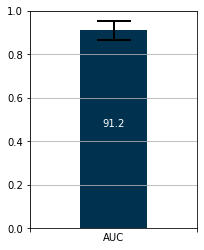

In [6]:
def bar_plot(location:int, val:float, name:str, color):
    plt.bar(location, val, color = color, width = .8)
    plt.text(location,val/2, np.round(100*val,1), ha='center', va='bottom',fontsize=10, color='white')
    plt.text(location,-.02, name, ha='center', va='top',fontsize=10)

        
def err_bar(x, ymin, ymax):
    cap_width = 0.2
    w = 2
    plt.vlines(x, ymin, ymax, colors='k', linestyles='solid', linewidths=w)
    plt.hlines(ymin, x-cap_width, x+cap_width, colors='k', linestyles='solid', linewidths=w)
    plt.hlines(ymax, x-cap_width, x+cap_width, colors='k', linestyles='solid', linewidths=w)

    
plt.figure(0, figsize=[3,4]);plt.grid();plt.ylim([0,1]); plt.xlim([-1, 1])  
bar_plot(location=0, val = auc, name = "AUC", color=[0/255,50/255,80/255])    
err_bar(0, ci[0], ci[1])
_ = plt.xticks(np.array([-1,1]), ["", ""])
_ = plt.yticks(np.arange(0,1.2,.2))

## Delong test

In [10]:
auc, auc_cov = compare_auc_delong_xu.delong_roc_variance(df.y_true, df.y_pred)
auc_std = np.sqrt(auc_cov)

alpha = .95
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

# ppf: inverse of cdf 
# input percentile- how much area of the distribution
# output - value of the variable with the given area from this point to the right
#loc, scale = mean, std of normal distribution
ci = stats.norm.ppf(lower_upper_q, loc=auc, scale=auc_std) 
ci[ci > 1] = 1

print('AUC:', "{:.5f}".format(float(auc)))
print('95% AUC CI:', ci)

AUC: 0.91222
95% AUC CI: [0.86872438 0.9557134 ]


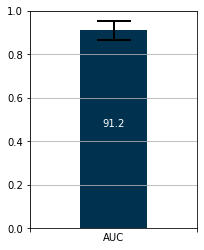

In [11]:
plt.figure(0, figsize=[3,4]);plt.grid();plt.ylim([0,1]); plt.xlim([-1, 1])  
bar_plot(location=0, val = auc, name = "AUC", color=[0/255,50/255,80/255])    
err_bar(0, ci[0], ci[1])
_ = plt.xticks(np.array([-1,1]), ["", ""])
_ = plt.yticks(np.arange(0,1.2,.2))

Plot

# p value to compare AUCs of two classifiers

## Bootstraping

The AUC of two classifiers statistically differ from each other if the p value is smaller than a cutoff (typically 0.05) 

In [12]:
def get_pvalue_bootstrap(y_pred, y_pred2, y_true, n_bootstraps = 1000, rng_seed = 42, statistic=roc_auc_score):
    bstrap_scores1 = []
    bstrap_scores2 = []
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:          
            # We need at least one positive and one negative sample for ROC AUC 
            continue
        bstrap_scores1.append(statistic(y_true[indices], y_pred[indices]))        
        bstrap_scores2.append(statistic(y_true[indices], y_pred2[indices]))

    bstrap_scores1 = np.array(bstrap_scores1)
    bstrap_scores2 = np.array(bstrap_scores2)
    
    cov = np.cov(bstrap_scores1, bstrap_scores2)
    z = (bstrap_scores1.mean() - bstrap_scores2.mean()) / \
        np.sqrt(cov[0,0] + cov[1,1] - 2*cov[1,0])
    def two_side_pvalue(z): #P(x<-Z or x>Z)
        return 2*(1 - stats.norm.cdf(abs(z)))
    
    return two_side_pvalue(z)


p_value = get_pvalue_bootstrap(df.y_pred, df.y_pred2, df.y_true)
print('p Value:',  "{:.5f}".format(p_value))


p Value: 0.00300


# Delong test

In [13]:
def get_pvalue_delong(y_pred, y_pred2, y_true):
    return np.power(10, float(compare_auc_delong_xu.delong_roc_test(np.array(y_true), np.array(y_pred), np.array(y_pred2))))
p_value = get_pvalue_delong(df.y_pred, df.y_pred2, df.y_true)
print('p Value:',  "{:.5f}".format(p_value))

p Value: 0.00321
